<a href="https://colab.research.google.com/github/s-shibata/Self_study/blob/master/tweet_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get -y install fonts-ipafont-gothic

In [0]:
from google.colab import files

uploaded = files.upload()

Saving tweets.csv to tweets.csv


In [0]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import re

In [0]:
df = pd.read_csv(io.StringIO(uploaded['tweets.csv'].decode('utf-8')))

df.head()

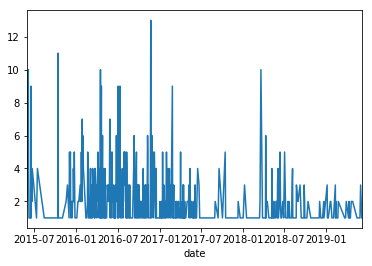

In [0]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

tweets_cnt = df.groupby('date').size()

tweets_cnt.plot()

In [0]:
def normalize_text(text):
    text = re.sub(r'\[.*?\]', "", text)
    text = re.sub(r'#', "", text)
    text = re.sub(r'\!', "", text)
    text = re.sub(r'\(.*', "", text)
    text = re.sub(r'.*\)', "", text)
    text = re.sub(r'\*', "", text)
    text = re.sub(r'\n', "", text)
    text = re.sub(r'\$.*', "", text)
    text = re.sub(r'`.*`', "", text)
    text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", text)
    text = re.sub('関連記事', "", text)
    text = re.sub('以下', "", text)
    text = re.sub('こと', "", text)
    text = re.sub('の', "", text)
    text = re.sub('さ', "", text)
    text = re.sub('これ', "", text)
    text = re.sub('よう', "", text)
    text = re.sub('Raspberry Pi', "RaspberryPi", text)
    text = text.strip()
    return text

In [0]:
text_list_pandas = df['text'][df['retweeted_status_id'].isnull()].values.tolist()

In [0]:
text_list = []
for text in text_list_pandas:
    text = normalize_text(text)
    text_list.append(text)

In [0]:
!pip install janome

In [0]:
from janome.tokenizer import Tokenizer
from collections import Counter, defaultdict

In [0]:
def counter(texts):
    t = Tokenizer()
    words_count = defaultdict(int)
    words = []
    for text in texts:
        tokens = t.tokenize(text)
        for token in tokens:
            # 品詞から名詞だけ抽出
            pos = token.part_of_speech.split(',')[0]
            if pos == '名詞':
                words_count[token.base_form] += 1
                words.append(token.base_form)
    return words_count, words

words_count, words = counter(text_list)
text = ' '.join(words)
# print(text) for debug

In [0]:
with open('analysis_text.txt', 'w', encoding='utf-8') as f:
    f.write(text)
files.download('analysis_text.txt') 

In [0]:
!pip install wordcloud

In [0]:
from wordcloud import WordCloud

In [0]:
f = open('analysis_text.txt')
text = f.read()
f.close()

In [0]:
!cd ../../
!ls

analysis_text.txt  sample_data	tweets.csv


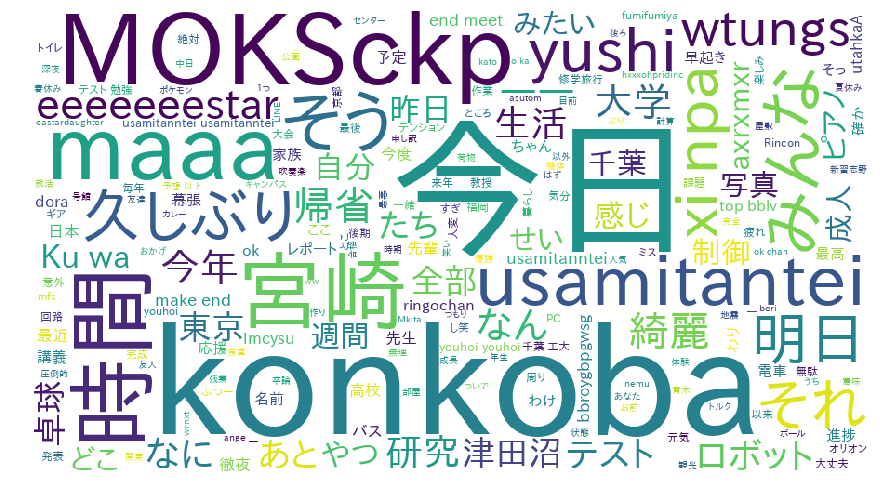

In [0]:
fpath = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500).generate(text)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
!pip install gensim

In [0]:
from gensim.models import word2vec
import logging　
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # 今どれくらい処理が進んでるか確認する用
sentences = word2vec.LineSentence('analysis_text.txt')
model = word2vec.Word2Vec(sentences,
                          sg=1,         #0: CBOW, 1: skip-gram
                          size=300,     # ベクトルの次元数
                          window=5,    # 入力単語からの最大距離
                          min_count=5,  # 単語の出現回数でフィルタリング
                          )

model.save("./word2vec.model")

In [0]:
with open('vector.tsv', 'w', encoding='utf-8') as f, \
     open('metadata.tsv', 'w', encoding='utf-8') as g:

    # metadata file needs header for over two words
    # g.write('Word\n')

    for word in model.wv.vocab.keys():
        embedding = model.wv[word]

        # Save vector TSV file
        f.write('\t'.join([('%f' % x) for x in embedding]) + '\n')

        # Save metadata TSV file
        g.write(word + '\n')


files.download('vector.tsv')
files.download('metadata.tsv')